In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import random

In [ ]:
torch.cuda.empty_cache()
del model
# del ds, train_loader, val_loader, test_loader

In [2]:
class OnePieceDataset(Dataset):

    def __init__(self, transform=None):
        xy = torch.load('/kaggle/input/op-greyscale/onepiecedata_greyscale.pt')

        # Images saved in tuples, stacking adds a new dimension as 'batch'
        self.transform = transform
        self.x = torch.stack([tuple[0] for tuple in xy])
        self.y = [tuple[1] for tuple in xy]
        self.num_samples = self.x.shape[0]
        self.mean = 131.67                    # pre-computed
        self.stdev = 85.40                    # pre-computed

        # print(f'[DATASET INFO: image shapes {xy[0][0].shape}. Image example {self.__getitem__(0)}')

    def __getitem__(self, index):
        return ((self.x[index]- self.mean)/self.stdev), self.y[index]

    def __len__(self):
        return self.num_samples


def get_data_loaders(batch_size):

    dataset = OnePieceDataset()
    X_train, X_test, y_train, y_test = train_test_split(dataset.x, dataset.y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

    train = TensorDataset(X_train, torch.tensor(y_train))
    val = TensorDataset(X_val, torch.tensor(y_val))
    test = TensorDataset(X_test, torch.tensor(y_test))

    train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

    return dataset, train_loader, validation_loader, test_loader


### The Network

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


class CNN(nn.Module):

    def __init__(self, num_classes) -> None:
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=3)
            nn.AdaptiveAvgPool2d((4, 4)),
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=4096, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
        )

        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)
        self.dropout = nn.Dropout(p=0.6)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)

        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.fc3(x)
        return x
        

model = CNN(num_classes=18).to(device)
_ = model.forward(torch.rand([64, 1, 180, 180]).to(device))

cuda


## Parameters

In [10]:
num_classes = 18
lr = 1e-3
num_epochs = 40

ds, train_loader, val_loader, test_loader = get_data_loaders(batch_size=64)
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [5]:
def get_validation_loss():
    model.eval()
    val_loss = []
    with torch.no_grad():
      for i, (data, targets) in enumerate(val_loader):

        data = data.float().to(device)
        data = data.unsqueeze(1)

        targets = targets.to(device)

        # forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        val_loss.append(loss.item())

    model.train()
    return np.mean(val_loss)


In [6]:
def train_model():

    train_loss = []
    val_loss = []
    acc = []
    val_acc = []


    for epoch in range(num_epochs):

        epoch_losses = []

        # print(f"[TRAINING] epoch {epoch+1}")
        for i, (data, targets) in enumerate(train_loader):

            data = data.float().to(device)
            # print(f'HERE: {data.shape}')

            data = data.unsqueeze(1) # Add channel dimension

            targets = targets.to(device)

            # forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # gradient descent
            optimizer.step()

            if (i+1) % 20 == 0:
                epoch_losses.append(loss.item())

        # Epoch validation and training loss
        mean_epoch_loss = np.mean(epoch_losses)
        val_epoch_loss = get_validation_loss()

        # Get training and validation accuracy for the epoch
        _, _, val_correct, val_samples = check_accuracy(val_loader, model)
        _, _, train_correct, train_samples = check_accuracy(train_loader, model)
        val_epoch_acc = val_correct/val_samples
        train_epoch_acc = train_correct/train_samples

        print(
            f"epoch: [{epoch+1}/{num_epochs}], loss: {mean_epoch_loss:.4f}, acc: {train_epoch_acc:.4f}, val_loss: {val_epoch_loss:.4f}, val_acc: {val_epoch_acc:.4f}"
        )
        train_loss.append((epoch, mean_epoch_loss))
        val_loss.append((epoch, val_epoch_loss))
        acc.append((epoch, train_epoch_acc))
        val_acc.append((epoch, val_epoch_acc))

    print("Model finished training.\n")
    return train_loss, val_loss, acc, val_acc



In [7]:
def check_accuracy(loader, model, msg=""):
    print(msg)
    y_true = []
    y_pred = []

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            y = y.to(device)
            x = x.float().to(device)
            x = x.unsqueeze(1) # Add channel dimension

            scores = model(x)
            predictions = torch.argmax(scores, dim=1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            y_true.append(y.cpu())
            y_pred.append(predictions.cpu())
    model.train()
    return torch.cat(y_true), torch.cat(y_pred), num_correct, num_samples


In [11]:
loss_metrics, val_loss_metrics, train_acc, val_acc = train_model()

# Final train set accuracy
_, _, num_correct, num_samples = check_accuracy(train_loader, model, msg="[EVAL] Checking accuracy on training dataset")
print(f"[EVAL] Correctly classified {num_correct}/{num_samples} - Accuracy {(float(num_correct)/float(num_samples))*100:.2f}%")

# Final test set accuracy
y_true, y_pred, num_correct, num_samples = check_accuracy(test_loader, model, msg="[EVAL] Checking accuracy on test dataset")
print(f"[EVAL] Correctly classified {num_correct}/{num_samples} - Accuracy {(float(num_correct)/float(num_samples))*100:.2f}%")




epoch: [1/40], loss: 2.8450, acc: 0.1129, val_loss: 2.8691, val_acc: 0.1008


epoch: [2/40], loss: 2.6859, acc: 0.2375, val_loss: 2.4675, val_acc: 0.2285


epoch: [3/40], loss: 2.4027, acc: 0.2753, val_loss: 2.3582, val_acc: 0.2647


epoch: [4/40], loss: 2.2837, acc: 0.3124, val_loss: 2.3187, val_acc: 0.2938


epoch: [5/40], loss: 2.2501, acc: 0.2940, val_loss: 2.4066, val_acc: 0.2676


epoch: [6/40], loss: 2.1133, acc: 0.3030, val_loss: 2.5593, val_acc: 0.2839


epoch: [7/40], loss: 2.0845, acc: 0.3738, val_loss: 2.3393, val_acc: 0.3073


epoch: [8/40], loss: 2.0431, acc: 0.4707, val_loss: 1.9743, val_acc: 0.3903


epoch: [9/40], loss: 1.8078, acc: 0.5422, val_loss: 1.8274, val_acc: 0.4507


epoch: [10/40], loss: 1.7502, acc: 0.4427, val_loss: 2.2931, val_acc: 0.3612


epoch: [11/40], loss: 1.5606, acc: 0.5342, val_loss: 1.9993, val_acc: 0.4336


epoch: [12/40], loss: 1.3978, acc: 0.5383, val_loss: 1.9591, val_acc: 0.4081


epoch: [13/40], loss: 1.3202, acc: 0.5496, val_loss: 2.2822

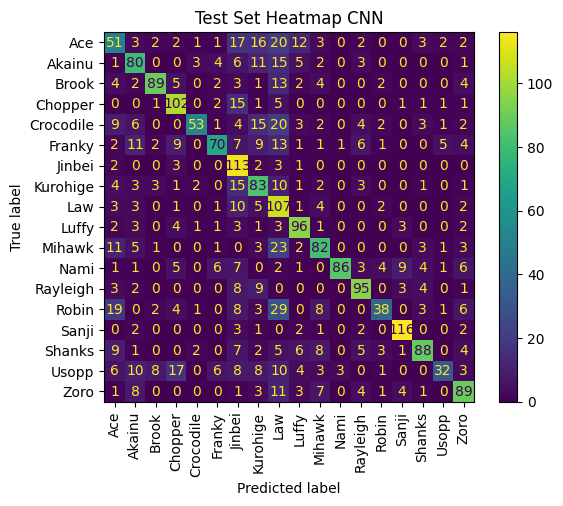

In [12]:
cnfm = metrics.confusion_matrix(y_true, y_pred)
class_labels = {
    0: 'Ace',
    1: 'Akainu',
    2: 'Brook',
    3: 'Chopper',
    4: 'Crocodile',
    5: 'Franky',
    6: 'Jinbei',
    7: 'Kurohige',
    8: 'Law',
    9: 'Luffy',
    10: 'Mihawk',
    11: 'Nami',
    12: 'Rayleigh',
    13: 'Robin',
    14: 'Sanji',
    15: 'Shanks',
    16: 'Usopp',
    17: 'Zoro'
}
displayed_cm = metrics.ConfusionMatrixDisplay(cnfm, display_labels=list(class_labels.values()))
displayed_cm.plot()
plt.xticks(rotation=90)
plt.title('Test Set Heatmap CNN')
plt.show()

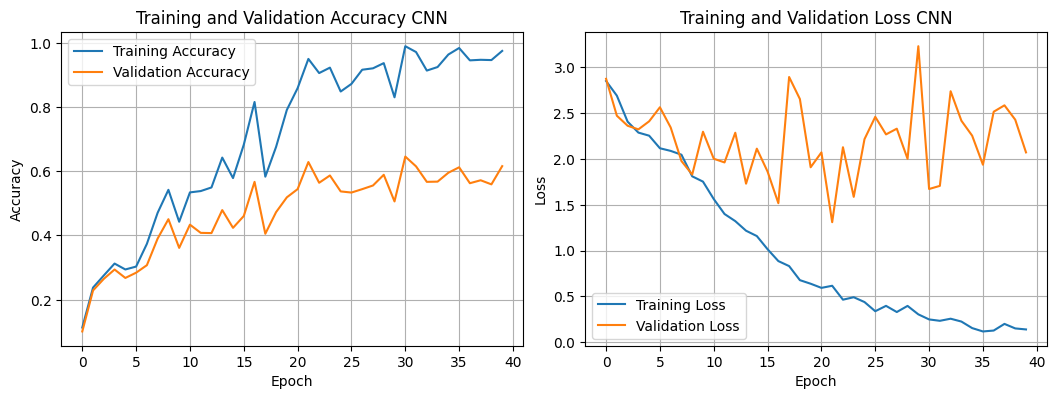

In [13]:
fig = plt.figure(figsize=(10, 4.75))
subfigs = fig.subfigures(1, 2, wspace=0.1)

acc_fig = subfigs[0].add_subplot(1, 1, 1)
loss_fig = subfigs[1].add_subplot(1, 1, 1)

# Subfigure 1: Accuracy
acc_fig.plot([x[0] for x in train_acc], [x[1].cpu() for x in train_acc], label='Training Accuracy')
acc_fig.plot([x[0] for x in val_acc], [x[1].cpu() for x in val_acc], label='Validation Accuracy')
acc_fig.set_xlabel('Epoch')
acc_fig.set_ylabel('Accuracy')
acc_fig.set_title('Training and Validation Accuracy CNN')
acc_fig.legend()
acc_fig.grid(True)

# Subfigure 2: Loss
loss_fig.plot([x[0] for x in loss_metrics], [x[1] for x in loss_metrics], label='Training Loss')
loss_fig.plot([x[0] for x in val_loss_metrics], [x[1] for x in val_loss_metrics], label='Validation Loss')
loss_fig.set_xlabel('Epoch')
loss_fig.set_ylabel('Loss')
loss_fig.set_title('Training and Validation Loss CNN')
loss_fig.legend()
loss_fig.grid(True)

plt.tight_layout()
plt.show()

Batch index: 7


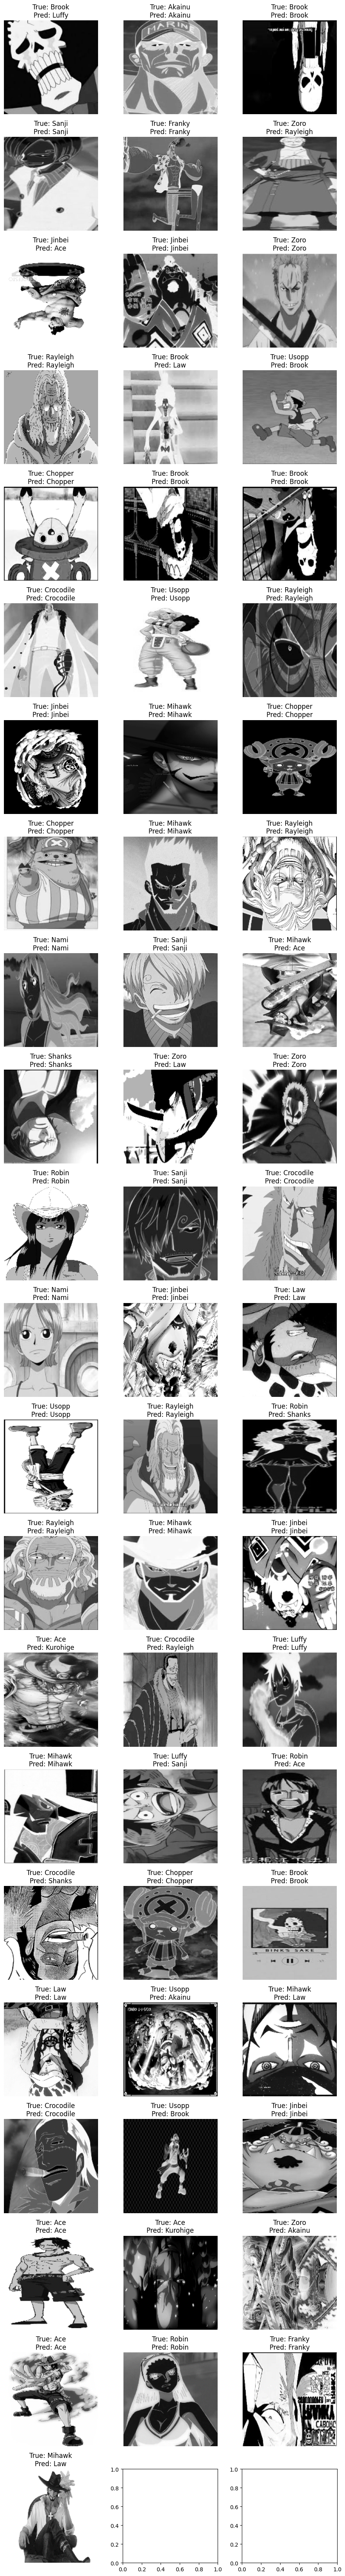

In [14]:
# Plotting calculations visually

loader_length = len(test_loader)
idx = random.randint(0, loader_length-1)
loader_batch = None

for i, (data, targets) in enumerate(test_loader):
    if idx == i:
        print(f"Batch index: {i}")
        loader_batch = (data, targets)
        break
    

model.eval()
with torch.no_grad():

    x, y = loader_batch
    y = y.cpu()
    x = x.float().to(device)
    x = x.unsqueeze(1) # Add channel dimension

    scores = model(x)
    predictions = torch.argmax(scores, dim=1)

    y_label = [class_labels[int(el)] for el in y]
    y_pred = [class_labels[int(el)] for el in predictions]

    cols = 3
    rows = (len(y) + cols - 1) // 3

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()


    # Plot images
    for i in range(len(y)):
      real = y_label[i]
      pred = y_pred[i]

      raw_img = x[i]
      unnormalized_img = (raw_img * ds.stdev) + ds.mean
      rescaled_img = (unnormalized_img - unnormalized_img.min()) / (unnormalized_img.max() - unnormalized_img.min())

      axes[i].imshow(rescaled_img.squeeze(0).cpu(), cmap='gray')
      axes[i].set_title(f"True: {real}\nPred: {pred}")
      axes[i].axis('off')


    # Turn off extra axes
    for j in range(len(y)):
      axes[j].axis('off')

    plt.tight_layout()
    plt.show()